In [12]:
%load_ext autoreload
%autoreload 2
import SpectralConvxD as spc
import numpy as np
import tensorflow as tf
import copy 
from typing import Any



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
x_train, y_train,x_test, y_test=spc.generate_data(name_data='mnist1d')


Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...


In [41]:
maxpooling_config ={'strides': 1,
                     'padding': 'valid' }

hyperparameters = { 'filters' :20,
                    'input_shape' :(40,),
                    'learning_rate' : 0.03,
                    'epochs' : 20,
                    'batch_size' :100,
                    'activation': 'relu',
                    'labels' : 20,
                    'conxd':1,
                    'pool_size':2,
                    'full_training':True,
                    'pre_training': False,
                    }

In [17]:
replication = {'rep':5} 
depth={'N':[2500]}
drop={'p':[0,0.05,0.1,0.15,0.2,0.25, 0.3,0.35, 0.4,0.45, 0.5,0.55, 0.6,0.65, 0.7, 0.75,0.8, 0.85,0.9,0.95,1]}
path =r"C:\Users\jketchak\Documents\DALPHAcommunity\UNAMUR\EUREKA\btwg_ml\SpectralConvxD\SpectralConvxD\DataWarehouse\dtest"
path=spc.utils.remplacer_backslash(path)

In [45]:
# Pre-training weights diag_end
inv=2
hyperparameters['pre_training']=True
hyperparameters['full_training']=False
models_pars,models_name= spc.pars()
models = spc.SpectralCnn(hyperparameters=hyperparameters,maxpooling_config=maxpooling_config)
models.compile_models(units=2500,spectral_config=models_pars.get(models_name[inv]).get('spectral_config'),
                      spectral_cnn1d_config=models_pars.get(models_name[inv]).get('spectral_cnn1d_config'),
                      spectral_cnn2d_config=models_pars.get(models_name[inv]).get('spectral_cnn2d_config'),
                      name=models_name[inv],
                      layers_name=['convx','spec1','spec2'],
                      layer_cible=None)
models.summary(name=models_name[inv])


Pre training: Spectral compactness
specConvXd model summary:
 


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convx (SpecCnn1D)               │ (None, 38, 20)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 37, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 740)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spec1 (Spectral)                │ (None, 2500)           │         5,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spec2 (Spectral)                │ (None, 20)             │        50,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,120 (215.31 KB)

 Trainable params: 55,100 (215.23 KB)

 Non-trainable params: 20 (80.00 B)

In [46]:
models.train(x_train, y_train, x_test, y_test, name=models_name[inv],verbose=1)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2520 - loss: 2.9503 - val_accuracy: 0.4910 - val_loss: 1.4078
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5401 - loss: 1.2875 - val_accuracy: 0.6285 - val_loss: 1.0761
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6809 - loss: 0.9961 - val_accuracy: 0.7530 - val_loss: 0.8336
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7912 - loss: 0.7500 - val_accuracy: 0.7645 - val_loss: 0.7710
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8208 - loss: 0.6450 - val_accuracy: 0.8080 - val_loss: 0.6403
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8510 - loss: 0.5738 - val_accuracy: 0.8175 - val_loss: 0.6412
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8680 - loss: 0.5238 - val_accuracy: 0.8480 - val_loss: 0.5551
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8753 - loss: 0.4901 - val_accuracy: 0.8510 - val_loss

In [ ]:
models.evaluate(x_test, y_test, trainable_weights=None, path=path, name=models_name[inv], order=0,layer_name='spec1',p=1,pre_pruning=False,save_accuracy=False)

In [ ]:
models_name[inv]

In [ ]:
pruning_weights, percentage_zeroed=models.percentile_spectral_filter(trainable_weights=models.trainable_weights['spec1'], name='specConvXd', layer_name='sepc1',p=0.1)

## Pruning model 

In [ ]:
for p in drop.get('p'):
    models.evaluate(x_test, y_test, name=models_name[inv],layers=[3],p=p,order=0,path=path)

In [32]:
results={name : spc.extract_accuracy_and_save(replication=replication,depth=depth,drop=drop,name=name,path=path) for name in ['Spectral-Pruning','Pre-training','Incoming-connectivity']}


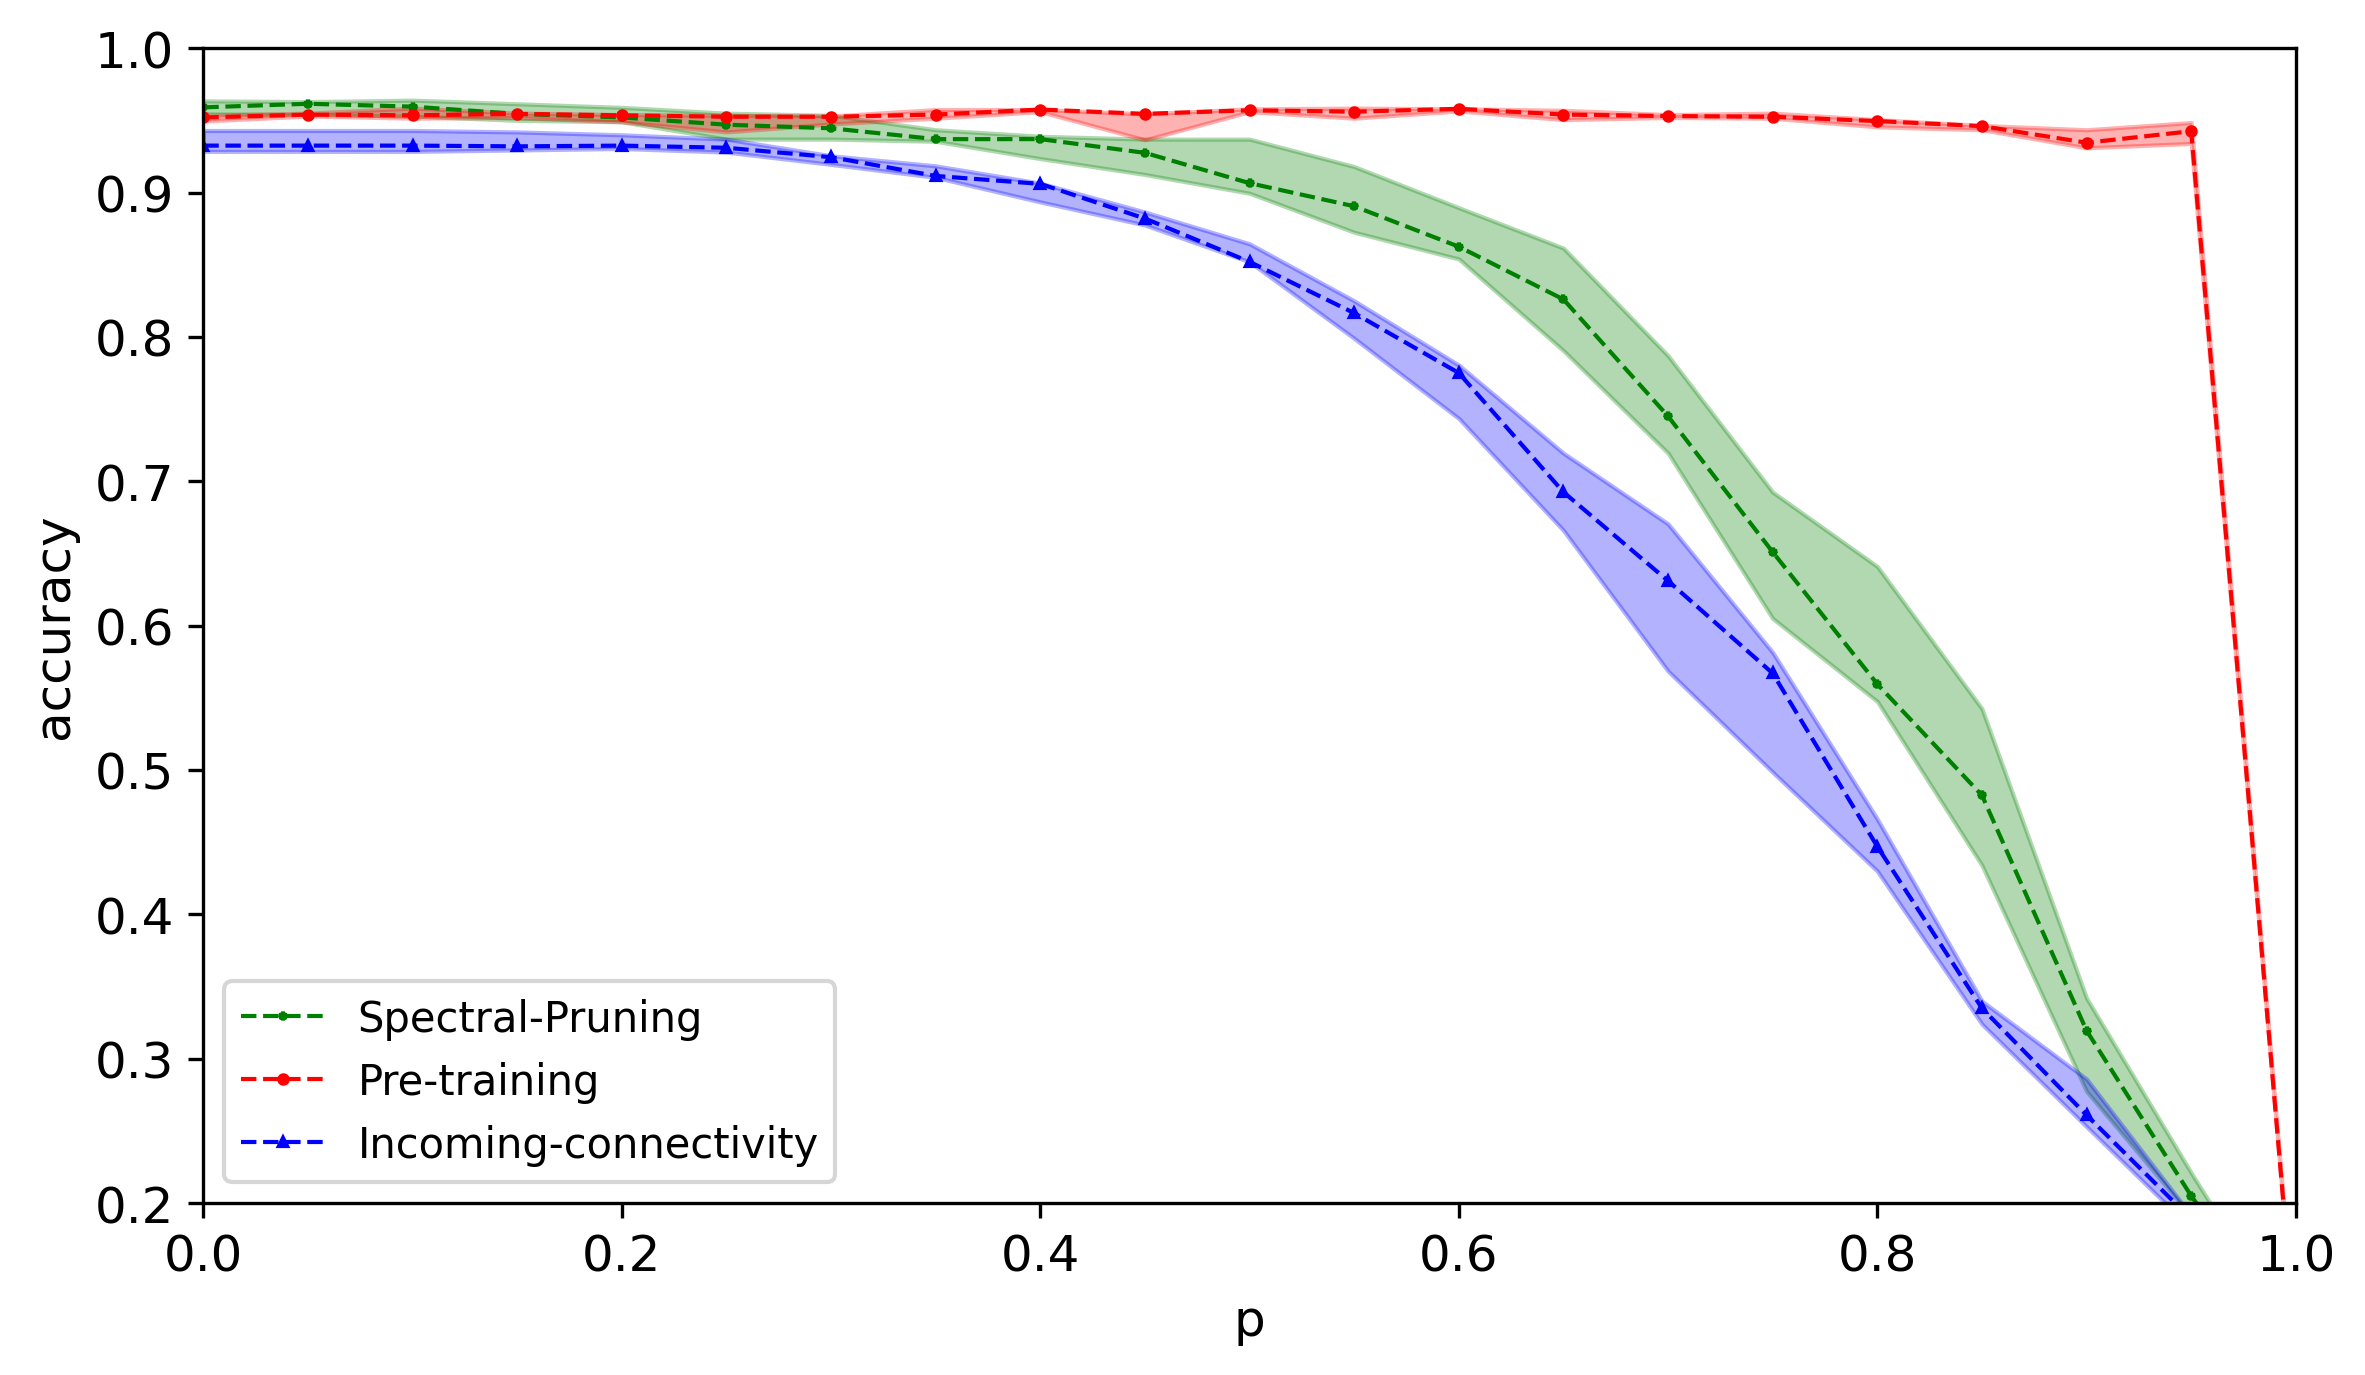

In [33]:
spc.plot_results(results,x_min=0,
            x_max=1,
            y_min=0.2,
            y_max=1.0,
            xlabel='p',
            ylabel='accuracy',
            show_fig=True,
            use_grid=False,
            markersize=2,
            percentile=True,
            save_fig=False,
            dpi=300,
            lw=1,
            alpha=0.3,
            loc='lower left',
            name_fig='results')

## Pre-training

In [ ]:
models_pars.get('specConvXd').get('spectral_cnn1d_config')['trainable_phi']=True
models_pars.get('specConvXd').get('spectral_cnn1d_config')['use_lambda_in']=False

In [ ]:
inv=2
hyperparameters['use_pruning']=False
models_pars.get('specConvXd').get('spectral_cnn1d_config')['trainable_phi']=True
models_pars.get('specConvXd').get('spectral_cnn1d_config')['use_lambda_in']=False
models = spc.SpectralCnn(hyperparameters=hyperparameters,maxpooling_config=maxpooling_config)
models.compile_models(units=2500,spectral_config=models_pars.get(models_name[inv]).get('spectral_config'),
                      spectral_cnn1d_config=models_pars.get(models_name[inv]).get('spectral_cnn1d_config'),
                      spectral_cnn2d_config=models_pars.get(models_name[inv]).get('spectral_cnn2d_config'),
                      name=models_name[inv])
models.summary(name=models_name[inv])
models.train(x_train, y_train, x_test, y_test, name=models_name[inv],verbose=1,layers=[3])

In [ ]:
models.weigths[0][0].shape

In [ ]:
import numpy as np
import tensorflow as tf

def zero_small_abs_values(obj, p, threshold):
    """
    Set to zero the p% smallest absolute values in the input, 
    only if they are below a given threshold.

    Args:
        obj (list, tuple, np.ndarray, tf.Tensor): Input data
        p (float): Fraction (0.0 - 1.0) of smallest absolute values to zero
        threshold (float): Maximum absolute value allowed for zeroing

    Returns:
        Same type as input, with selected values replaced by zero
    """
    # Validation des paramètres
    if not isinstance(p, (int, float)):
        raise ValueError("p must be a number between 0 and 1")
    if not 0 <= p <= 1:
        raise ValueError("p must be between 0 and 1")
    if not isinstance(threshold, (int, float)):
        raise ValueError("threshold must be a number")

    # Conversion en numpy
    input_type = type(obj)
    if isinstance(obj, tf.Tensor):
        arr = obj.numpy()
    elif isinstance(obj, (list, tuple)):
        arr = np.array(obj)
    elif isinstance(obj, np.ndarray):
        arr = obj.copy()
    else:
        raise ValueError("Input must be list, tuple, numpy array, or tf.Tensor")

    # Masque des valeurs valides
    mask_valid = np.isfinite(arr)
    arr_flat = arr.flatten()

    # Valeurs absolues pour sélection
    abs_vals = np.abs(arr_flat)

    # Filtre : valeurs valides et <= seuil
    valid_indices = np.where(mask_valid.flatten() & (abs_vals <= threshold))[0]
    n_total_valid = len(valid_indices)
    n_zero = int(np.floor(n_total_valid * p))

    if n_zero == 0:
        return obj  # Rien à changer

    # Trouver indices des plus petites valeurs absolues dans ce filtre
    sorted_indices = valid_indices[np.argsort(abs_vals[valid_indices])]
    indices_to_zero = sorted_indices[:n_zero]

    # Mise à zéro
    arr_flat[indices_to_zero] = 0
    arr_result = arr_flat.reshape(arr.shape)

    # Conversion retour au type d'origine
    if input_type is list:
        return arr_result.tolist()
    elif input_type is tuple:
        return tuple(arr_result.tolist())
    elif input_type is tf.Tensor:
        return tf.constant(arr_result, dtype=obj.dtype)
    else:
        return arr_result


In [ ]:
data = [0.1, -0.5, 3, -4, 0.2, 5, -0.3]
print(zero_small_abs_values(data, p=1, threshold=1))
# → met à zéro 50% des plus petites valeurs absolues qui sont ≤ 0.5


In [ ]:
class ReplicateInitializer(tf.keras.initializers.Initializer):
    def __init__(self, base_weights):
        """
        Parameters:
        - base_weights: numpy array or tf.Tensor of shape (m, K)
        """
        if not isinstance(base_weights, (np.ndarray, tf.Tensor)):
            raise ValueError("base_weights must be a numpy array or tf.Tensor")
        self.base_weights = np.array(base_weights, dtype=np.float32)
        self.m, self.K = self.base_weights.shape

    def __call__(self, shape, dtype=None):
        m, n = shape
        if m != self.m:
            raise ValueError(f"Shape mismatch: base_weights has m={self.m}, but target m={m}")
        
        # Réplication en colonnes jusqu'à atteindre n
        repeats = int(np.ceil(n / self.K))
        replicated = np.tile(self.base_weights, (1, repeats))[:, :n]  # coupe à n colonnes
        return tf.convert_to_tensor(replicated, dtype=dtype or tf.float32)

    def get_config(self):
        return {
            "base_weights": self.base_weights.tolist()
        }

In [ ]:
# Poids de base (m=3, K=2)
base_w = np.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

# Création de la couche avec initialisation personnalisée
layer = tf.keras.layers.Dense(
    units=6,  # n = 6
    input_shape=(3,),
    kernel_initializer=ReplicateInitializer(base_w),
    use_bias=False
)

# Vérification
model = tf.keras.Sequential([layer])
model.build((None, 3))
print(model.layers[0].get_weights()[0])